# Compare and Difference Model Run with Upscaled ASO Data

In [29]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rasterio as rio
from rasterio import plot, mask, features
import rioxarray 
import hvplot.xarray 
from rasterio.warp import reproject, Resampling
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# set temperature threshold. choices: [0,1,2]
threshold = 0
# set day. choices: ['20160329','20160208']
day_str = '20160329'
# set stat. choices: [0,1,2,3,4] represent ensemble [mean,std,median,25%,75%]
stat = 2

In [3]:
# set DOWY
if day_str == '20160329':
    day_num = 180
elif day_str == '20160208':
    day_num = 130
else:
    print('Invalid date')

In [4]:
print(f'Temperature Threshold = {threshold}K, Day = {day_str}, DOWY = {day_num}.')

Temperature Threshold = 0K, Day = 20160329, DOWY = 180.


In [5]:
#open model run netcdf
xds = xr.open_dataset(f"../SnowHydro/data/Model_Output/{threshold}K_Threshold/N47_0W124_0_agg_16_SWE_SCA_POST_WY2015_16.nc")
#xds

In [6]:
# select the day and stat we want from the model run, set spatial dimensions, and set crs
model_ds = xds['SWE_Post'].sel(Day=day_num,Stats=stat).T
model_ds.rio.set_spatial_dims('Longitude','Latitude',inplace=True)
model_ds.rio.set_crs('EPSG:4326',inplace=True);

In [7]:
# open ASO dataset, check crs
ASO_500m_ds = xr.open_rasterio(f'data/Olympics_ASO_SWE_2016/ASO_500m_SWE_USAWOL_{day_str}.tif')

Text(0.5, 0.98, 'Pre Reproject Match Comparison')

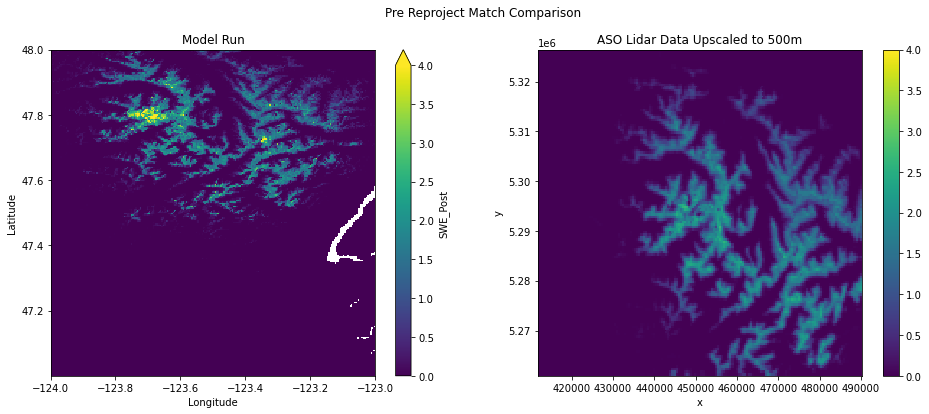

In [8]:
# comparing before reproject
f,ax = plt.subplots(1,2,figsize=(16,6))
model_ds.plot(ax=ax[0],vmin=0,vmax=4)
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4)
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
f.suptitle('Pre Reproject Match Comparison')

In [9]:
# reprojecting
model_reproject = model_ds.rio.reproject_match(ASO_500m_ds)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0.5, 0.98, 'Post Reproject Match Comparison')

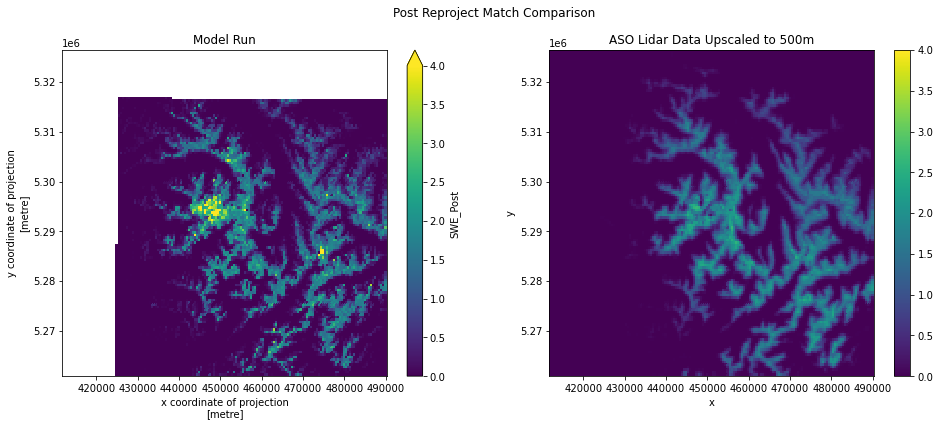

In [10]:
# post projection comparison
f, ax = plt.subplots(1,2,figsize=(16,6))
model_reproject.plot(ax=ax[0],vmin=0,vmax=4)
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4)
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
f.suptitle('Post Reproject Match Comparison')

In [11]:
# difference
difference = model_reproject - ASO_500m_ds

Text(0.5, 1.0, 'ASO - Model')

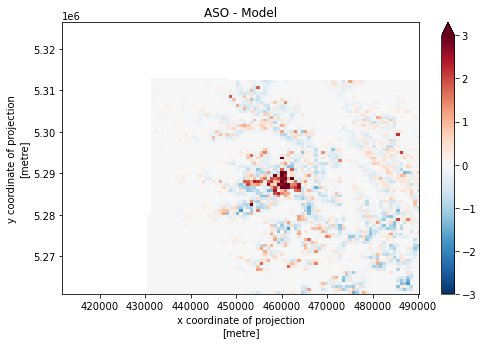

In [12]:
# show difference
f, ax = plt.subplots(figsize=(8,5))
difference.squeeze().plot.imshow(ax=ax,vmin=-3,vmax=3,cmap='RdBu_r')
ax.set_title('ASO - Model')

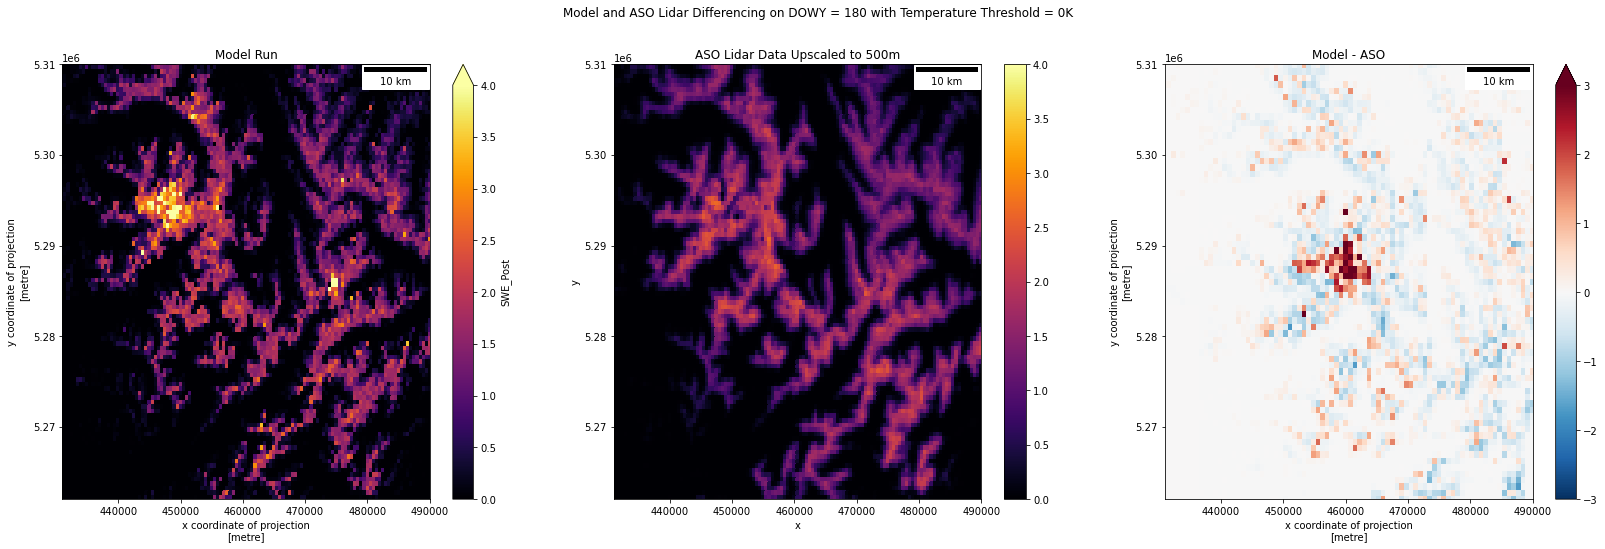

In [13]:
# plot differencing
f, ax = plt.subplots(1,3,figsize=(28,8)) 
model_reproject.plot(ax=ax[0],vmin=0,vmax=4,cmap='inferno')
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4,cmap='inferno')
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
difference.squeeze().plot.imshow(ax=ax[2],vmin=-3,vmax=3,cmap='RdBu_r')
ax[2].set_title('Model - ASO')
f.suptitle(f'Model and ASO Lidar Differencing on DOWY = {day_num} with Temperature Threshold = {threshold}K')
for i in range(len(ax)):
    ax[i].set_xlim([431000, 490000])
    ax[i].set_ylim([5.262e6, 5.31e6])
    ax[i].add_artist(ScaleBar(1.0))


In [14]:
glaciers_gdf = gpd.read_file('data/Glacier_shapefiles/glims_polygons.shp')

In [ ]:
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['latitude'], coords['longitude'])
    out_shape = (len(coords['latitude']), len(coords['longitude']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xray.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

# this shapefile is from natural earth data
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
#states = geopandas.read_file('/Users/shoyer/Downloads/ne_10m_admin_1_states_provinces_lakes')
#us_states = states.query("admin == 'United States of America'").reset_index(drop=True)
glaciers_gdf = gpd.read_file('data/Glacier_shapefiles/glims_polygons.shp')
glacier_ids = {k: i for i, k in enumerate(glaciers_gdf.woe_name)}
shapes = [(shape, n) for n, shape in enumerate(glaciers_gdf.geometry)]

#ds = xray.Dataset(coords={'longitude': np.linspace(-125, -65, num=5000),
#                          'latitude': np.linspace(50, 25, num=3000)})
difference['states'] = rasterize(shapes, difference.coords)

# example of applying a mask
ds.states.where(ds.states == state_ids['California']).plot()

In [15]:
#glaciers_gdf_proj = glaciers_gdf.to_crs('EPSG:32610')

In [16]:
#glacier_geom = glaciers_gdf_proj.geometry

In [52]:
#glacier_geom

0       POLYGON Z ((447576.246 5296328.201 0.000, 4475...
1       POLYGON Z ((473828.734 5286727.315 0.000, 4738...
2       POLYGON Z ((456903.259 5293032.288 0.000, 4569...
3       POLYGON Z ((446780.138 5295609.986 0.000, 4467...
4       POLYGON Z ((452012.492 5304607.853 0.000, 4520...
                              ...                        
1252    POLYGON Z ((475816.189 5285960.038 0.000, 4758...
1253    POLYGON Z ((451960.275 5294635.141 0.000, 4519...
1254    POLYGON Z ((452226.057 5305807.844 0.000, 4522...
1255    POLYGON Z ((451118.642 5296929.418 0.000, 4511...
1256    POLYGON Z ((455602.068 5296443.465 0.000, 4556...
Name: geometry, Length: 1257, dtype: geometry

In [53]:
#glacier_bounds = glacier_geom.total_bounds
#glacier_bounds

array([ 441244.7485933 , 5263250.67871586,  490745.47562569,
       5306588.14531761])

In [56]:
#def myround(x, base=0.25):
#    return base * np.round(x/base)

#def roundbounds(bounds, base=0.25):
#    bounds_floor = np.floor(bounds/base)*base
#    bounds_ceil = np.ceil(bounds/base)*base
#    return [bounds_floor[0], bounds_floor[1], bounds_ceil[2], bounds_ceil[3]]

In [57]:
#glacier_rbounds = roundbounds(glacier_bounds)
#glacier_rbounds

[441244.5, 5263250.5, 490745.5, 5306588.25]

In [58]:
#difference_masked_glaciers = difference.sel(y=slice(glacier_rbounds[3],glacier_rbounds[1]), x=slice(glacier_rbounds[0],glacier_rbounds[2]))

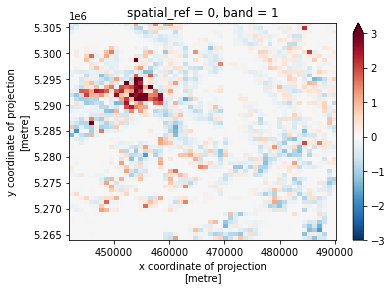

In [63]:
#f, ax = plt.subplots()
#difference_masked_glaciers.squeeze().plot.imshow(ax=ax,vmin=-3,vmax=3,cmap='RdBu_r')

In [37]:
difference.coords

Coordinates:
  * y            (y) float64 5.326e+06 5.326e+06 ... 5.264e+06 5.261e+06
  * x            (x) float64 4.12e+05 4.125e+05 4.13e+05 ... 4.895e+05 4.9e+05
    spatial_ref  int64 0
    band         int64 1

In [44]:
difference.reset_index('band').reset_coords(drop=True).coords

Coordinates:
  * y        (y) float64 5.326e+06 5.326e+06 5.325e+06 ... 5.264e+06 5.261e+06
  * x        (x) float64 4.12e+05 4.125e+05 4.13e+05 ... 4.895e+05 4.9e+05

In [50]:
raster = features.rasterize(glacier_geom,difference.reset_index('band').reset_coords(drop=True).coords)

KeyError: 0

In [18]:
#rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}

In [26]:
#glacier_ma, glacier_ma_transform = rio.mask.mask(difference.to_masked_array(), glacier_geom, **rio_mask_kwargs)

In [ ]:
#whidbey_ma, whidbey_out_transform = rio.mask.mask(src_proj, [whidbey_geom,], filled=False, crop=True, indexes=1)
#whidbey_ma_extent = rio.plot.plotting_extent(whidbey_ma, whidbey_out_transform)

In [ ]:
#color = ax.imshow(whidbey_ma, extent=whidbey_ma_extent,alpha=0.8,cmap='inferno');